In [1]:
import pandas as pd
from sklearn import datasets, linear_model, metrics
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

2025-01-16 10:19:45.025134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
train = pd.read_csv('../data/processed/train_data.csv', keep_default_na=False)
test = pd.read_csv('../data/processed/test_data.csv', keep_default_na=False)

In [3]:
#split input and output
X_train=train.drop(['SalePrice'], axis=1)
y_train= train['SalePrice']

X_test=test.drop(['SalePrice'], axis=1)
y_test= test['SalePrice']

In [4]:
#one hot encoding - convert categorical columns to numerical for linear regression. 
#there was an error with vanishing columns in test. This fixes it. 
X_train_one_hot = pd.get_dummies(X_train, drop_first=True) 
cols = X_train_one_hot.columns.tolist()
X_test_one_hot = pd.get_dummies(X_test, drop_first=True) 
X_test_one_hot = X_test_one_hot.reindex(columns=cols).fillna(0)

In [5]:
#Linear regression

In [6]:
#fit_intercept=False is needed as collinearity of one hot encoding, first row has to be dropped. 
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_one_hot, y_train)

LinearRegression(fit_intercept=False)

In [7]:
#predict sales price on test set
predictions_lm = reg.predict(X_test_one_hot)

In [8]:
#Apply inverse transformation to bring predictions back to the original scale
predictions_lm = np.exp(predictions_lm)

In [56]:
#RMSE 
rmse_lm = np.sqrt(mean_squared_error(np.exp(y_test), predictions_lm))
print(f'Root Mean Squared Error for Linear Regression Model: {rmse_lm}')

Root Mean Squared Error for Linear Regression Model: 5600584.853498658


In [57]:
#Tensorflow Decision Forest Models (TF-DF)
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [11]:
# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="SalePrice", task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="SalePrice", task = tfdf.keras.Task.REGRESSION)

In [59]:
#RandomForestModel

In [60]:
# Create a RandomSearch tuner
tuner_rf = tfdf.tuner.RandomSearch(num_trials=20)

tuner_rf.choice("num_trees", [100, 200, 500])
tuner_rf.choice("max_depth", [-1, 10, 30])
tuner_rf.choice("min_examples", [2, 5, 10])

In [61]:
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, tuner=tuner_rf)
model_rf.compile

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmp31rk11v4 as temporary training directory


<bound method InferenceCoreModel.compile of <tensorflow_decision_forests.keras.RandomForestModel object at 0x323e24a50>>

In [62]:
model_rf.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:00.330494. Found 1165 examples.
Training model...


[INFO 25-01-15 14:06:09.0896 EST kernel.cc:1233] Loading model from path /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmp31rk11v4/model/ with prefix 97b7341b317a4e0a


Model trained in 0:00:39.146081
Compiling model...


[INFO 25-01-15 14:06:09.3536 EST decision_forest.cc:734] Model loaded with 500 root(s), 218842 node(s), and 80 input feature(s).
[INFO 25-01-15 14:06:09.3537 EST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-15 14:06:09.3537 EST kernel.cc:1061] Use fast generic engine


Model compiled.


In [63]:
tuning_logs_rf = model_rf.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_rf[tuning_logs_rf.best].iloc[0]

score              -0.152176
evaluation_time    31.007573
best                    True
num_trees                500
max_depth                 10
min_examples               2
Name: 17, dtype: object

In [64]:
model_rf.compile(metrics=["accuracy"])
print(model_rf.evaluate(test_ds))

1/1 [==============================] - 0s 186ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


In [65]:
inspector = model_rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1165, accuracy=None, loss=None, rmse=0.15217643958890595, ndcg=None, aucs=None, auuc=None, qini=None)

In [66]:
#note this RMSE is on the logarmithic data, not the actual data! 

In [67]:
#calculate the actual RMSE
predictions_rf_log = model_rf.predict(test_ds)

1/1 [==============================] - 0s 89ms/step


In [68]:
predictions_rf=np.exp(predictions_rf_log)

In [69]:
rmse_rf = np.sqrt(mean_squared_error(np.exp(y_test), predictions_rf))
print(f'Root Mean Squared Error for TF-DF Random Forest: {rmse_rf}')

Root Mean Squared Error for TF-DF Random Forest: 34789.153809252544


In [70]:
#GradientBoostedTreesModel

In [71]:
# Create a RandomSearch tuner
tuner_gb = tfdf.tuner.RandomSearch(num_trials=10)

tuner_gb.choice("num_trees", [50, 100, 200, 500, 1000])
tuner_gb.choice("shrinkage", [0.01, 0.05, 0.1, 0.3, 0.5])
tuner_gb.choice("max_depth", [3, 4, 5, 6, 8, 10])
tuner_gb.choice("min_examples", [2, 5, 10, 15])

In [72]:
# Initialize and train Gradient Boosted Trees Regression model
model_gb_regressor = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    tuner=tuner_gb
)

model_gb_regressor.fit(train_ds)
print("Model training complete.")

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpy0om9j_q as temporary training directory
Reading training dataset...


[WARNING 25-01-15 14:06:16.9609 EST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-15 14:06:16.9618 EST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-15 14:06:16.9618 EST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.610287. Found 1165 examples.
Training model...
Model trained in 0:00:09.814821
Compiling model...


[INFO 25-01-15 14:06:27.3915 EST kernel.cc:1233] Loading model from path /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpy0om9j_q/model/ with prefix 280fd0106ec14077
[INFO 25-01-15 14:06:27.3924 EST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 25-01-15 14:06:27.3924 EST kernel.cc:1061] Use fast generic engine


Model compiled.
Model training complete.


In [73]:
tuning_logs_gb = model_gb_regressor.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_gb[tuning_logs_gb.best].iloc[0]

score             -0.159583
evaluation_time     1.08091
best                   True
num_trees                50
shrinkage               0.3
max_depth                 4
min_examples              2
Name: 3, dtype: object

In [74]:
# Make predictions on test dataset
predictions_gb_log = model_gb_regressor.predict(test_ds)

# Reverse log transformation for predictions
predictions_gb = np.exp(predictions_gb_log)

# Reverse the log transformation for true variable
y=test['SalePrice']

1/1 [==============================] - 0s 102ms/step


In [75]:
# Calculate RMSE and evaluate model performance
rmse_gb = np.sqrt(mean_squared_error(np.exp(y), predictions_gb))
print(f'Root Mean Squared Error for TF-DF Gradient Boosted Trees: {rmse_gb}')

Root Mean Squared Error for TF-DF Gradient Boosted Trees: 28356.90959290289


In [76]:
#CartModel

In [77]:
#train model
model_cm_regression = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)
model_cm_regression.fit(train_ds)

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpvu1bv5yz as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.348830. Found 1165 examples.
Training model...
Model trained in 0:00:00.031573
Compiling model...


[INFO 25-01-15 14:07:15.7906 EST kernel.cc:1233] Loading model from path /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpvu1bv5yz/model/ with prefix 12a7910b92384c1c
[INFO 25-01-15 14:07:15.7910 EST decision_forest.cc:734] Model loaded with 1 root(s), 101 node(s), and 21 input feature(s).
[INFO 25-01-15 14:07:15.7910 EST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-15 14:07:15.7911 EST kernel.cc:1061] Use fast generic engine


Model compiled.


In [78]:
# Make predictions on the same dataset (or test set)
predictions_log_cm = model_cm_regression.predict(test_ds)

# Reverse the log transformation (use np.exp to get the original scale)
predictions_cm = np.exp(predictions_log_cm)

1/1 [==============================] - 0s 100ms/step


In [79]:
rmse_cm = np.sqrt(mean_squared_error(np.exp(y), predictions_cm))
print(f'Root Mean Squared Error for TF-DF Cart Model: {rmse_cm}')

Root Mean Squared Error for TF-DF Cart Model: 45776.47002119163


In [80]:
#Basic sklearn Random Forest

In [81]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train_one_hot, y_train)

RandomForestRegressor(oob_score=True, random_state=0)

In [82]:
predictions_regressor_log = regressor.predict(X_test_one_hot)
predictions_regressor = np.exp(predictions_regressor_log)

In [85]:
mse_rf = mean_squared_error(np.exp(y_test), predictions_regressor)
print(f'Mean Squared Error for sklearn Random Forest: {mse_rf}')

Mean Squared Error for sklearn Random Forest: 1127542967.1339123


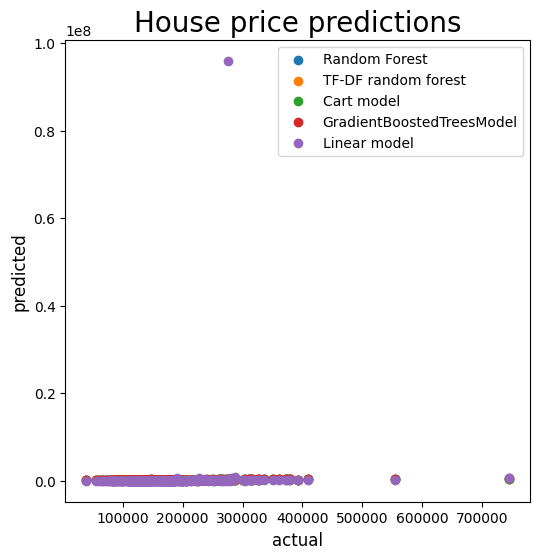

In [86]:
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title('House price predictions',fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(np.exp(y_test), predictions_regressor,label='Random Forest')
    ax.scatter(np.exp(y), predictions_rf,label='TF-DF random forest')
    ax.scatter(np.exp(y), predictions_cm,label='Cart model')
    ax.scatter(np.exp(y), predictions_gb,label='GradientBoostedTreesModel')
    ax.scatter(np.exp(y_test), predictions_lm,label='Linear model')
    ax.legend()


In [87]:
# Map model names to their corresponding classes
models = {
    "gradient_boosted_trees": tfdf.keras.GradientBoostedTreesModel,
    "random_forest": tfdf.keras.RandomForestModel
}

# Define model hyperparameter configurations
params = {
    "gradient_boosted_trees": {
        "num_trees": [50, 100, 200, 500, 1000],
        "shrinkage": [0.01, 0.05, 0.1, 0.3, 0.5],
        "max_depth": [3, 4, 5, 6, 8, 10],
        "min_examples": [2, 5, 10, 15]
    },
    "random_forest": {
        "num_trees": [100, 200, 500],
        "max_depth": [-1, 10, 30],
        "min_examples": [2, 5, 10]
    }
}

num_trials = {
    "gradient_boosted_trees": 10,
    "random_forest": 20
}

# Placeholder to store model output
output_logs = []

In [88]:
# Train each model
for model_name, config in params.items():
    output_logs.append(f"Training and tuning {model_name}...")

    num_trial = num_trials.get(model_name, 10)  # Get the number of trials for the model
    tuner = tfdf.tuner.RandomSearch(num_trials=num_trial)
    
    # Loop through the configuration dictionary and set the hyperparameters
    for param, values in config.items():
        tuner.choice(param, values)
    
    model_class = models[model_name]  # Get the corresponding model class
    model = model_class(task=tfdf.keras.Task.REGRESSION, tuner=tuner)
    
    model.fit(train_ds)

    #get best parameters
    tuning_logs = model.make_inspector().tuning_logs()
    best_params = tuning_logs[tuning_logs.best].iloc[0]
    
    predictions_log = model.predict(test_ds)
    y_pred = np.exp(predictions_log)
    y_true = np.exp(y_test)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    output_logs.append(f"Best parameters for {model_name}: {best_params}")
    output_logs.append(f"Best RMSE for {model_name}: {rmse:.6f}")

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpr4zjriby as temporary training directory
Reading training dataset...


[WARNING 25-01-15 14:08:34.9304 EST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-15 14:08:34.9304 EST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-15 14:08:34.9304 EST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.328653. Found 1165 examples.
Training model...
Model trained in 0:00:09.754847
Compiling model...


[INFO 25-01-15 14:08:45.0182 EST kernel.cc:1233] Loading model from path /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpr4zjriby/model/ with prefix 6dd44884c81a43d3
[INFO 25-01-15 14:08:45.0191 EST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 25-01-15 14:08:45.0191 EST kernel.cc:1061] Use fast generic engine


Model compiled.


1/1 [==============================] - 0s 72ms/step
Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpkt7aq3lh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.297603. Found 1165 examples.
Training model...


[INFO 25-01-15 14:09:24.1456 EST kernel.cc:1233] Loading model from path /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpkt7aq3lh/model/ with prefix cb7a7e03941141f1


Model trained in 0:00:38.553663
Compiling model...


[INFO 25-01-15 14:09:24.4099 EST decision_forest.cc:734] Model loaded with 500 root(s), 218842 node(s), and 80 input feature(s).
[INFO 25-01-15 14:09:24.4100 EST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-15 14:09:24.4100 EST kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 88ms/step


In [89]:
for log in output_logs:
    print(log)

Training and tuning gradient_boosted_trees...
Best parameters for gradient_boosted_trees: score             -0.159583
evaluation_time    1.070461
best                   True
num_trees                50
shrinkage               0.3
max_depth                 4
min_examples              2
Name: 3, dtype: object
Best RMSE for gradient_boosted_trees: 28356.909593
Training and tuning random_forest...
Best parameters for random_forest: score              -0.152176
evaluation_time    30.739577
best                    True
num_trees                500
max_depth                 10
min_examples               2
Name: 17, dtype: object
Best RMSE for random_forest: 34789.153809


In [ ]:
#gradient boosting has the lowest RMSE. That will be used for the final model. 

In [24]:
#merge train_ds and test_ds
total_ds=pd.concat([train,test])

In [26]:
total_ds = tfdf.keras.pd_dataframe_to_tf_dataset(total_ds, label="SalePrice", task = tfdf.keras.Task.REGRESSION)


In [16]:
# Create a RandomSearch tuner
tuner_gb = tfdf.tuner.RandomSearch(num_trials=10)

tuner_gb.choice("num_trees", [50, 100, 200, 500, 1000])
tuner_gb.choice("shrinkage", [0.01, 0.05, 0.1, 0.3, 0.5])
tuner_gb.choice("max_depth", [3, 4, 5, 6, 8, 10])
tuner_gb.choice("min_examples", [2, 5, 10, 15])

In [28]:
# Initialize and train Gradient Boosted Trees Regression model
model_gb_regressor = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    tuner=tuner_gb
)

model_gb_regressor.fit(total_ds)
print("Model training complete.")

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpaed_v44c as temporary training directory
Reading training dataset...


[WARNING 25-01-16 10:33:07.9384 GMT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-16 10:33:07.9384 GMT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-16 10:33:07.9384 GMT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:05.191709. Found 1457 examples.
Training model...
Model trained in 0:00:12.593861
Compiling model...


[INFO 25-01-16 10:33:25.7468 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpaed_v44c/model/ with prefix b5c5379621584ccb
[INFO 25-01-16 10:33:25.7553 GMT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 25-01-16 10:33:25.7562 GMT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 25-01-16 10:33:25.7562 GMT kernel.cc:1061] Use fast generic engine


Model compiled.
Model training complete.


In [29]:
tuning_logs_gb = model_gb_regressor.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_gb[tuning_logs_gb.best].iloc[0]

score             -0.158382
evaluation_time    3.302366
best                   True
num_trees               500
shrinkage              0.05
max_depth                 4
min_examples             10
Name: 5, dtype: object

In [65]:
#load testing data set 
testing = pd.read_csv('../data/raw/test.csv')

In [66]:
testing.fillna('None', inplace=True)


In [72]:
testing = tfdf.keras.pd_dataframe_to_tf_dataset(testing, task = tfdf.keras.Task.REGRESSION)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [46]:
# Make predictions on test dataset
predictions_gb_log = model_gb_regressor.predict(testing)

# Reverse log transformation for predictions
predictions_gb = np.exp(predictions_gb_log)


ValueError: in user code:

    File "/Users/admin/anaconda3/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 486, in run_step  *
        outputs = model.predict_step(data)
    File "/Users/admin/anaconda3/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 2377, in predict_step  *
        return self(x, training=False)
    File "/Users/admin/anaconda3/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 565, in error_handler  *
        del filtered_tb
    File "/Users/admin/anaconda3/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 588, in __call__  *
        return super().__call__(*args, **kwargs)
    File "/Users/admin/anaconda3/lib/python3.11/site-packages/tf_keras/src/engine/training.py", line 560, in error_handler  *
        filtered_tb = _process_traceback_frames(e.__traceback__)
    File "/Users/admin/anaconda3/lib/python3.11/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_filel9puqnkl.py", line 162, in error_handler  **
        raise ag__.converted_call(ag__.ld(new_e).with_traceback, (ag__.ld(e).__traceback__,), None, fscope_1) from None
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_filel9puqnkl.py", line 34, in error_handler
        retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_file3lfsir1x.py", line 232, in tf__call
        ag__.if_stmt(ag__.ld(self)._semantics is None, if_body_8, else_body_8, get_state_11, set_state_11, ('do_return', 'retval_'), 2)
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_file3lfsir1x.py", line 43, in else_body_8
        normalized_inputs = ag__.converted_call(ag__.ld(self)._build_normalized_inputs, (ag__.ld(inputs),), None, fscope)
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_filey80y390p.py", line 99, in tf___build_normalized_inputs
        normalized_semantic_inputs = ag__.converted_call(ag__.ld(tf_core).normalize_inputs, (ag__.ld(semantic_inputs),), dict(categorical_integer_offset_correction=ag__.not_(ag__.ld(self)._advanced_arguments.disable_categorical_integer_offset_correction)), fscope)
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_fileml0jtodi.py", line 205, in tf__normalize_inputs
        ag__.for_stmt(ag__.converted_call(ag__.ld(inputs).items, (), None, fscope), None, loop_body, get_state_13, set_state_13, (), {'iterate_names': '(key, semantic_tensor)'})
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_fileml0jtodi.py", line 201, in loop_body
        ag__.if_stmt(ag__.ld(semantic_tensor).semantic in [ag__.ld(Semantic).NUMERICAL, ag__.ld(Semantic).DISCRETIZED_NUMERICAL], if_body_12, else_body_12, get_state_12, set_state_12, ('normalized_inputs[key]',), 1)
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_fileml0jtodi.py", line 60, in if_body_12
        ag__.if_stmt(ag__.ld(semantic_tensor).tensor.dtype in ag__.ld(FlexibleNumericalTypes), if_body, else_body, get_state, set_state, (), 0)
    File "/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/__autograph_generated_fileml0jtodi.py", line 59, in else_body
        raise ag__.converted_call(ag__.ld(ValueError), (ag__.converted_call('Non supported tensor dtype {} for semantic {} of feature {}'.format, (ag__.ld(semantic_tensor).tensor.dtype, ag__.ld(semantic_tensor).semantic, ag__.ld(key)), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'gradient_boosted_trees_model_1' (type GradientBoostedTreesModel).
    
    in user code:
    
        File "/Users/admin/anaconda3/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 672, in call  *
            normalized_inputs = self._build_normalized_inputs(inputs)
        File "/Users/admin/anaconda3/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 634, in _build_normalized_inputs  *
            normalized_semantic_inputs = tf_core.normalize_inputs(
        File "/Users/admin/anaconda3/lib/python3.11/site-packages/tensorflow_decision_forests/tensorflow/core_inference.py", line 220, in normalize_inputs  *
            raise ValueError(
    
        ValueError: Non supported tensor dtype <dtype: 'string'> for semantic Semantic.NUMERICAL of feature LotFrontage
    
    
    Call arguments received by layer 'gradient_boosted_trees_model_1' (type GradientBoostedTreesModel):
      • inputs={'Id': 'tf.Tensor(shape=(None,), dtype=int64)', 'MSSubClass': 'tf.Tensor(shape=(None,), dtype=int64)', 'MSZoning': 'tf.Tensor(shape=(None,), dtype=string)', 'LotFrontage': 'tf.Tensor(shape=(None,), dtype=string)', 'LotArea': 'tf.Tensor(shape=(None,), dtype=int64)', 'Street': 'tf.Tensor(shape=(None,), dtype=string)', 'Alley': 'tf.Tensor(shape=(None,), dtype=string)', 'LotShape': 'tf.Tensor(shape=(None,), dtype=string)', 'LandContour': 'tf.Tensor(shape=(None,), dtype=string)', 'Utilities': 'tf.Tensor(shape=(None,), dtype=string)', 'LotConfig': 'tf.Tensor(shape=(None,), dtype=string)', 'LandSlope': 'tf.Tensor(shape=(None,), dtype=string)', 'Neighborhood': 'tf.Tensor(shape=(None,), dtype=string)', 'Condition1': 'tf.Tensor(shape=(None,), dtype=string)', 'Condition2': 'tf.Tensor(shape=(None,), dtype=string)', 'BldgType': 'tf.Tensor(shape=(None,), dtype=string)', 'HouseStyle': 'tf.Tensor(shape=(None,), dtype=string)', 'OverallQual': 'tf.Tensor(shape=(None,), dtype=int64)', 'OverallCond': 'tf.Tensor(shape=(None,), dtype=int64)', 'YearBuilt': 'tf.Tensor(shape=(None,), dtype=int64)', 'YearRemodAdd': 'tf.Tensor(shape=(None,), dtype=int64)', 'RoofStyle': 'tf.Tensor(shape=(None,), dtype=string)', 'RoofMatl': 'tf.Tensor(shape=(None,), dtype=string)', 'Exterior1st': 'tf.Tensor(shape=(None,), dtype=string)', 'Exterior2nd': 'tf.Tensor(shape=(None,), dtype=string)', 'MasVnrType': 'tf.Tensor(shape=(None,), dtype=string)', 'MasVnrArea': 'tf.Tensor(shape=(None,), dtype=string)', 'ExterQual': 'tf.Tensor(shape=(None,), dtype=string)', 'ExterCond': 'tf.Tensor(shape=(None,), dtype=string)', 'Foundation': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtQual': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtCond': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtExposure': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtFinType1': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtFinSF1': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtFinType2': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtFinSF2': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtUnfSF': 'tf.Tensor(shape=(None,), dtype=string)', 'TotalBsmtSF': 'tf.Tensor(shape=(None,), dtype=string)', 'Heating': 'tf.Tensor(shape=(None,), dtype=string)', 'HeatingQC': 'tf.Tensor(shape=(None,), dtype=string)', 'CentralAir': 'tf.Tensor(shape=(None,), dtype=string)', 'Electrical': 'tf.Tensor(shape=(None,), dtype=string)', '1stFlrSF': 'tf.Tensor(shape=(None,), dtype=int64)', '2ndFlrSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'LowQualFinSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'GrLivArea': 'tf.Tensor(shape=(None,), dtype=int64)', 'BsmtFullBath': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtHalfBath': 'tf.Tensor(shape=(None,), dtype=string)', 'FullBath': 'tf.Tensor(shape=(None,), dtype=int64)', 'HalfBath': 'tf.Tensor(shape=(None,), dtype=int64)', 'BedroomAbvGr': 'tf.Tensor(shape=(None,), dtype=int64)', 'KitchenAbvGr': 'tf.Tensor(shape=(None,), dtype=int64)', 'KitchenQual': 'tf.Tensor(shape=(None,), dtype=string)', 'TotRmsAbvGrd': 'tf.Tensor(shape=(None,), dtype=int64)', 'Functional': 'tf.Tensor(shape=(None,), dtype=string)', 'Fireplaces': 'tf.Tensor(shape=(None,), dtype=int64)', 'FireplaceQu': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageType': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageYrBlt': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageFinish': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageCars': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageArea': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageQual': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageCond': 'tf.Tensor(shape=(None,), dtype=string)', 'PavedDrive': 'tf.Tensor(shape=(None,), dtype=string)', 'WoodDeckSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'OpenPorchSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'EnclosedPorch': 'tf.Tensor(shape=(None,), dtype=int64)', '3SsnPorch': 'tf.Tensor(shape=(None,), dtype=int64)', 'ScreenPorch': 'tf.Tensor(shape=(None,), dtype=int64)', 'PoolArea': 'tf.Tensor(shape=(None,), dtype=int64)', 'PoolQC': 'tf.Tensor(shape=(None,), dtype=string)', 'Fence': 'tf.Tensor(shape=(None,), dtype=string)', 'MiscFeature': 'tf.Tensor(shape=(None,), dtype=string)', 'MiscVal': 'tf.Tensor(shape=(None,), dtype=int64)', 'MoSold': 'tf.Tensor(shape=(None,), dtype=int64)', 'YrSold': 'tf.Tensor(shape=(None,), dtype=int64)', 'SaleType': 'tf.Tensor(shape=(None,), dtype=string)', 'SaleCondition': 'tf.Tensor(shape=(None,), dtype=string)'}
      • training=False
